# Full code for an N-Body simulation

We now have every thing we need to implement a fairly efficient N-Body solver.
For the sake of simplicity, the equations of motions will be integrated forward in time using the `solve_ivp` function from `scipy.integrate`.
It gives access to fairly standard yet efficient time-integrators (e.g. high-order Runge-Kutta schemes).
Note that, for the problem we consider, energy-preserving schemes (e.g. symplectic time-integrators) might be better.
It however requires other packages that we won't cover herein.
If you want to know more, you can check for instance [diffeqpy](https://github.com/SciML/diffeqpy), a Python wrapper for the incredible Julia package [DifferentialEquations.jl](https://diffeq.sciml.ai/dev) providing such symplectic integrators.

**<center> N-Body simulator using only NumPy and SciPy</center>**

In [1]:
# --> Import needed packages/functions.
import numpy as np
from scipy.integrate import solve_ivp

def pairwise_interactions(X):
    """Computation of the net forces resulting from pairwise interactions."""
    # --> Number of particles.
    n = len(X)
    
    # --> Gram matrix.
    d2 = -2 * X @ X.T
    
    # --> Squared pairwise distances.
    diag = -0.5 * np.einsum('ii->i', d2)
    d2 += diag + diag[:, None]
    
    # --> Prevent division by zero.
    np.einsum('ii->i', d2)[...] = 1
    
    # --> Net forces.
    F = np.nansum( (X[:, None, :] - X) * d2[..., None]**-1.5, axis=0)
    
    return F

def nbody(t, u, ndim):
    """Right-hand side function for the N-Body simulation."""
    # --> Number of particles.
    n = len(u) // (2*ndim)
    
    # --> Initialize output vector.
    du = np.zeros_like(u)
    
    # --> Extract the positions and velocities.
    x, dx = u[:ndim*n], u[ndim*n:]
    
    # --> Compute the acceleration.
    ddx = pairwise_interactions(x.reshape(n, ndim))

    # --> Return the time-derivatives for the ODE solver.
    du[:ndim*n] = dx
    du[ndim*n:] = ddx.ravel()
       
    return du
    
def simulation(x, dx, t):
    
    # --> Number of dimensions/Number of particles.
    assert x.shape == dx.shape
    n, ndim = x.shape

    # --> Initial condition for the simulation.
    u = np.r_[x.flatten(), dx.flatten()]
    
    # --> Parameters for the ODE solver.
    tspan = (t.min(), t.max())
    t_eval = t
    method = "DOP853"
    atol = rtol = 1e-13
    
    # --> Run the simulation.
    output = solve_ivp(
        lambda t, u : nbody(t, u, ndim),
        tspan,
        u,
        t_eval=t_eval,
        method=method,
        atol=atol,
        rtol=rtol
    )
    
    # --> Extract the positions and velocities of the n particles.
    x = output["y"][:n*ndim].reshape((n, ndim, -1))
    dx = output["y"][n*ndim:].reshape((n, ndim, -1))

    return x, dx

The function `simulation` takes as input:
- `x` : Initial positions of the particles as a numpy array of size `n` by `ndim` with `n` the number of particles and `ndim` the dimension of the space considered.
- `dx` : Initial velocities of the particles as a numpy array of size `n` by `ndim`.
- `t` : The time points at which we'd like to save the simulation (typically a `np.linspace`).

It returns the positions and velocities of the particles over time as numpy arrays of size `(n, ndim, len(t))`.

The animation below shows the results of simulation a 4-Body problem with the following initial conditions

$$
\mathbf{X}
=
\begin{bmatrix}
    0 & 0 \\
    0 & 1 \\
    1 & 1 \\
    1 & 0
\end{bmatrix}
\quad
\dot{\mathbf{X}}
=
\begin{bmatrix}
    1 & 0 \\
    0 & -1 \\
    -1 & 0 \\
    0 & 1
\end{bmatrix}.
$$

The particles thus initially form a unit square and their initial velocities are arranged such that the evolution is time-periodic.

In [2]:
n, ndim = 4, 2

x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
dx = np.array([[1, 0], [0, -1], [0, 1], [-1, 0]])

t = np.linspace(0, 3.0, 1024)

X, dX = simulation(x, dx, t)

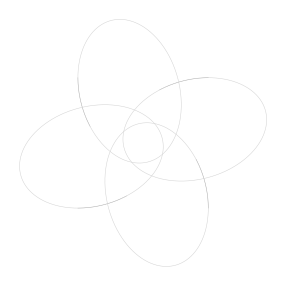

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for x in X:
    ax.plot(x[0], x[1], color="lightgray", lw=0.5)

ln, = ax.plot([], [], "o")
    
ax.axis(False);
ax.set_aspect("equal")

def update(i):
    ln.set_data(X[:, 0, i], X[:, 1, i])
    return ln

anim = FuncAnimation(fig, update, frames=len(t), interval=10);

In [4]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

The code is now yours to play with!
You can consider any initial arrangement of particles you'd like.
Note however that, since we implemented a **particle-particle method**, the computation rapidly gets extremely expensive as you increase the number of particles.
You can try to see how many you can simulate in a reasonnable time on your own laptop.

## Project ideas to go further

The code we've implemented is fairly simple and can be used as the skeleton for more advanced simulations.
Whether you are a student keen on taking challenges or a teacher looking for project ideas for your classes, here is a non-exhaustive list of how you build upon this code :
- At the begining, we've made the assumptions that all particles had unit mass and we set the gravitational constant to $G = 1$.
This was made out of necessity to focus on the core of the solver.
You can however easily change this and add support for particles with different masses and set $G$ to whatever value you like in your numerical universe.
- The gravitational potential becomes singular as the distance $r$ between two particles goes to zero.
This forces the time-stepper to take increasingly smaller time steps and massively increases the computational time.
If two particles happen to collide, it might even cause the whole simulation to blow up.
Different techniques have been proposed in the literature to remedy this problem.
- N-Body simulations do not have to be restricted to astrophysical situations.
Other potentials can be considered.
A good project would be to implement a similar code for the [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential).
It is considered an archetype model for simple yet realistic intermolecular interactions.
This would be a good starting project for students interested in [Molecular Dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics).

For more advanced project ideas, you can also look into other methods than the particle-particle one.
These other methods are typically used when you consider an enormous number of particles for which the particle-particle method yields intractable computations.